In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

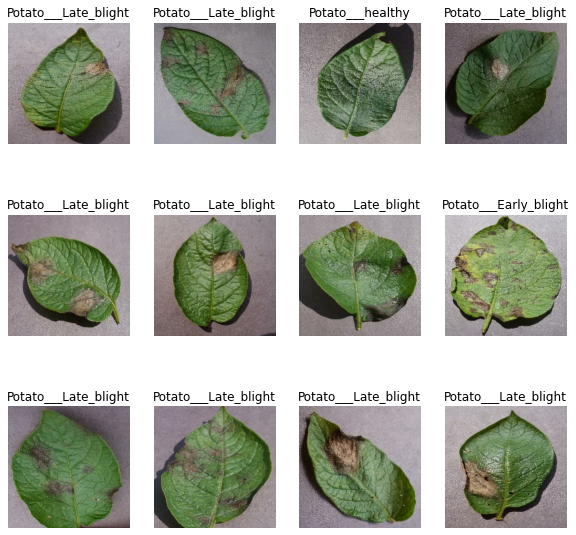

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch.shape)
    #print(label_batch.numpy())

In [7]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return(train_ds, val_ds, test_ds)

In [8]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(val_ds)

6

In [11]:
len(test_ds)

8

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 11s 91ms/step - loss: 0.9061 - accuracy: 0.4954 - val_loss: 0.7351 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 4s 66ms/step - loss: 0.7103 - accuracy: 0.6817 - val_loss: 0.5313 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 4s 66ms/step - loss: 0.4855 - accuracy: 0.7951 - val_loss: 0.3898 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 4s 66ms/step - loss: 0.4180 - accuracy: 0.8183 - val_loss: 0.2891 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 4s 66ms/step - loss: 0.3174 - accuracy: 0.8681 - val_loss: 0.3513 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 4s 66ms/step - loss: 0.3254 - accuracy: 0.8692 - val_loss: 0.2151 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 4s 66ms/step - loss: 0.3044 - accuracy: 0.8791 - val_loss: 0.2956 - val_accuracy: 0.8646
Epoch 8/50
5

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 21ms/step - loss: 0.0174 - accuracy: 0.9961


In [20]:
scores

[0.017431380227208138, 0.99609375]

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

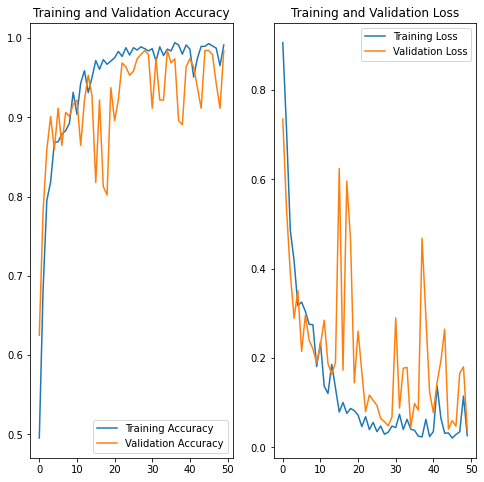

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


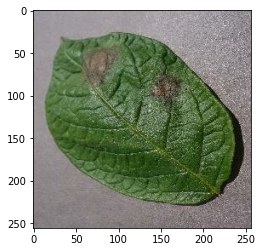

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

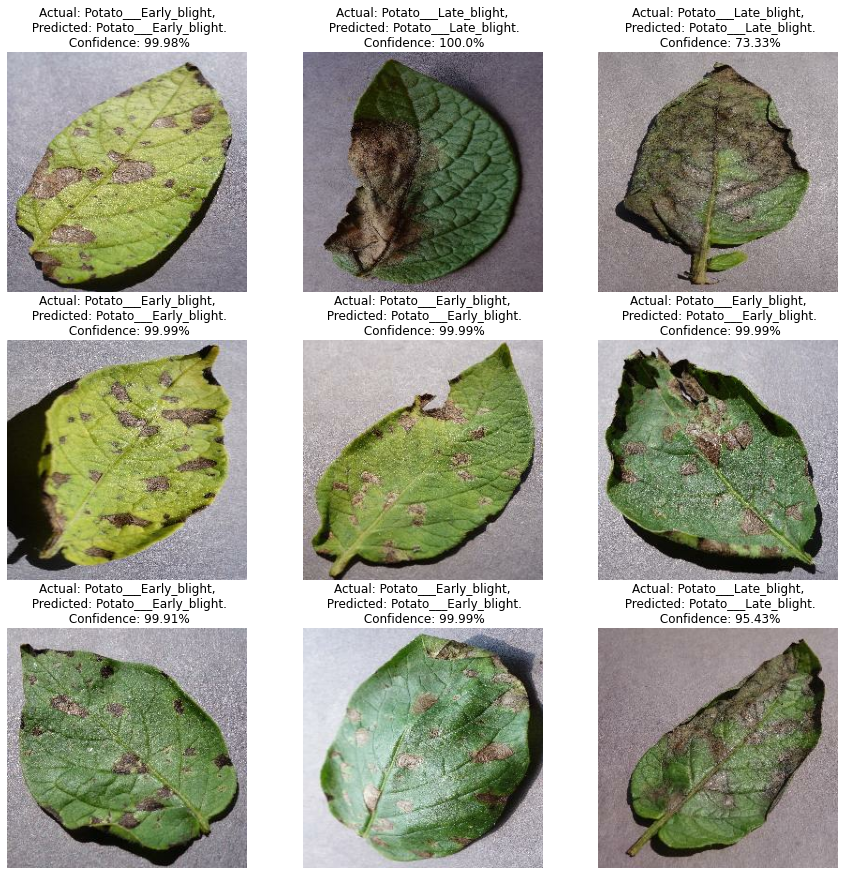

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [49]:
model.save("potato_model.h5")